In [ ]:
from glob import glob
import os
import pandas as pd
from PIL import Image
from torchvision import transforms as T
from torchvision import models
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm


class FrameImageDataset(torch.utils.data.Dataset):
    def __init__(self, 
    root_dir = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_4/ufc10',
    split='train', 
    transform=None
):
        self.frame_paths = sorted(glob(f'{root_dir}/frames/{split}/*/*/*.jpg'))
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform
       
    def __len__(self):
        return len(self.frame_paths)

    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]


    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        video_name = frame_path.split('\\')[-2] # Windows
        #video_name = frame_path.split('/')[-2] # Linux
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()
        
        frame = Image.open(frame_path).convert("RGB")

        if self.transform:
            frame = self.transform(frame)
        else:
            frame = T.ToTensor()(frame)

        return frame, label


class FrameVideoDataset(torch.utils.data.Dataset):
    def __init__(self, 
    root_dir = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_4/ufc10', 
    split = 'train', 
    transform = None,
    stack_frames = True
):

        self.video_paths = sorted(glob(f'{root_dir}/videos/{split}/*/*.avi'))
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform
        self.stack_frames = stack_frames
        
        self.n_sampled_frames = 10

    def __len__(self):
        return len(self.video_paths)
    
    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        video_name = video_path.split('\\')[-1].split('.avi')[0] # Windows
        #video_name = video_path.split('/')[-1].split('.avi')[0] # Linux
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()

        video_frames_dir = self.video_paths[idx].split('.avi')[0].replace('videos', 'frames')
        video_frames = self.load_frames(video_frames_dir)

        if self.transform:
            frames = [self.transform(frame) for frame in video_frames]
        else:
            frames = [T.ToTensor()(frame) for frame in video_frames]
        
        if self.stack_frames:
            frames = torch.stack(frames).permute(1, 0, 2, 3)


        return frames, label
    
    def load_frames(self, frames_dir):
        frames = []
        for i in range(1, self.n_sampled_frames + 1):
            frame_file = os.path.join(frames_dir, f"frame_{i}.jpg")
            frame = Image.open(frame_file).convert("RGB")
            frames.append(frame)

        return frames



In [13]:
from torch.utils.data import DataLoader

root_dir = r'C:/Users/Frederik/Programming/IntroductionToComputerVison/Project_4/ufc10'


batch_size = 8
transform = T.Compose([T.Resize((64, 64)),T.ToTensor()])
# Validation
val_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
val_framevideostack_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames = True)
val_framevideolist_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames = False)

val_frameimage_loader = DataLoader(val_frameimage_dataset,  batch_size=batch_size, shuffle=False)
val_framevideostack_loader = DataLoader(val_framevideostack_dataset,  batch_size=batch_size, shuffle=False)
val_framevideolist_loader = DataLoader(val_framevideolist_dataset,  batch_size=batch_size, shuffle=False)

# Train
train_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
train_framevideostack_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames = True)
train_framevideolist_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames = False)

train_frameimage_loader = DataLoader(train_frameimage_dataset,  batch_size=batch_size, shuffle=False)
train_framevideostack_loader = DataLoader(train_framevideostack_dataset,  batch_size=batch_size, shuffle=False)
train_framevideolist_loader = DataLoader(train_framevideolist_dataset,  batch_size=batch_size, shuffle=False)

# Test
test_frameimage_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)
test_framevideostack_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames = True)
test_framevideolist_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames = False)

test_frameimage_loader = DataLoader(test_frameimage_dataset,  batch_size=batch_size, shuffle=False)
test_framevideostack_loader = DataLoader(test_framevideostack_dataset,  batch_size=batch_size, shuffle=False)
test_framevideolist_loader = DataLoader(test_framevideolist_dataset,  batch_size=batch_size, shuffle=False)


# for frames, labels in frameimage_loader:
#     print(frames.shape, labels.shape) # [batch, channels, height, width]

# for video_frames, labels in framevideolist_loader:
#     print(45*'-')
#     for frame in video_frames: # loop through number of frames
#         print(frame.shape, labels.shape)# [batch, channels, height, width]

for video_frames, labels in val_framevideostack_loader:
    print(video_frames.shape, labels.shape) # [batch, channels, number of frames, height, width]
    break
        


torch.Size([8, 3, 10, 64, 64]) torch.Size([8])


In [16]:
print(f"Number of samples in train_framevideostack_loader: {len(train_framevideostack_loader) * train_framevideostack_loader.batch_size}")
print(f"Number of samples in test_framevideostack_loader: {len(test_framevideostack_loader) * test_framevideostack_loader.batch_size}")
print(f"Number of samples in val_framevideostack_loader: {len(val_framevideostack_loader) * val_framevideostack_loader.batch_size}")

Number of samples in train_framevideostack_loader: 504
Number of samples in test_framevideostack_loader: 120
Number of samples in val_framevideostack_loader: 120


In [ ]:
# Feature extractor for individual frames using ResNet50
class FramesExtractor(nn.Module):
    def __init__(self, fine_tune=False):
        super(FramesExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer

        # Using same approach as with EfficientNet, Freeze layers unless fine-tuning
        if not fine_tune:
            for param in self.resnet.parameters():
                param.requires_grad = False
        else:
            for name, param in self.resnet.named_parameters():
                if 'layer4' in name or 'fc' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

    def forward(self, x):
        return self.resnet(x)  # Output: [batch, 2048]

class LateFusionNetwork(nn.Module):
    def __init__(self, num_classes=10, fine_tune=False):
        super(LateFusionNetwork, self).__init__()

        self.frames_extractor = FramesExtractor(fine_tune=fine_tune)

        # Instead of only a linear, I'm including a dropout for regularization
        self.fc = nn.Sequential(
            nn.Dropout(0.6),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        batch_size, channels, num_frames, height, width = x.shape # Unpacking the data.

        # process all frames independently: [batch*num_frames, channels, height, width]
        x = x.view(-1, channels, height, width)

        # Pass each frame through the feature extractor
        frame_features = self.frames_extractor(x)  # [batch*num_frames, 2048]

        # [batch, num_frames, 2048]
        frame_features = frame_features.view(batch_size, num_frames, -1)

        # Average pooling across frames
        fused_features = torch.mean(frame_features, dim=1)  # [batch, 2048]
        out = self.fc(fused_features)  # [batch, num_classes]
        return out

# Example usage
model = LateFusionNetwork(num_classes=10, fine_tune=True) 
input_data = torch.randn(8, 3, 10, 64, 64)  # [batch_size, channels, num_frames, height, width]
output = model(input_data)
print(output.shape)  # Expected output: [batch_size, num_classes]


c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 10])


In [ ]:
"""
I'm not entirely happy with how it turned out tbh, 
the model will overfit and shortly there after stop getting useful generalization so to mitigate that I'm using early stopping.
However, the model does perform well on the test set so that is the caveat. 
I found adding more complexity to the model only results in lack of actual learning with validation results on 10% acc so I didn't pursue that route. 
With the limited time, this is likely the best I can come up with and it does perform well enough but having to finetune a trained network to get "good" results does ick me a bit. 
"""

def evaluate_model(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for frames, labels in loader:
            frames, labels = frames.to(device), labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return val_loss / len(loader), accuracy


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LateFusionNetwork(num_classes=10, fine_tune=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001, lr=0.001)

epochs = 100
patience = 3  #
best_val_loss = float('inf')  # Initialize the best validation loss to inf
no_improvement_counter = 0 
early_stop_start_epoch = 30  

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # Training loop
    for frames, labels in train_framevideostack_loader:
        frames, labels = frames.to(device), labels.to(device)
        
        outputs = model(frames)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_acc = 100 * correct / total
    
    val_loss, val_acc = evaluate_model(model, val_framevideostack_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{epochs}] " f"Train Loss: {train_loss/len(train_framevideostack_loader):.4f}, Train Acc: {train_acc:.2f}% " f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if epoch >= early_stop_start_epoch:

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_counter = 0  
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improvement_counter += 1
        
        # Early stopping condition: stop if no improvement after 'patience' epochs
        if no_improvement_counter >= patience:
            print(f"Early stopping.. ")
            break


Epoch [1/100] Train Loss: 3.9071, Train Acc: 8.40% Val Loss: 5.0883, Val Acc: 10.00%
Epoch [2/100] Train Loss: 2.7090, Train Acc: 0.80% Val Loss: 15.4072, Val Acc: 10.83%
Epoch [3/100] Train Loss: 2.6061, Train Acc: 0.00% Val Loss: 7.9625, Val Acc: 10.00%
Epoch [4/100] Train Loss: 2.5115, Train Acc: 0.80% Val Loss: 7.3214, Val Acc: 12.50%
Epoch [5/100] Train Loss: 2.4630, Train Acc: 2.00% Val Loss: 11.1366, Val Acc: 12.50%
Epoch [6/100] Train Loss: 2.4371, Train Acc: 4.60% Val Loss: 7.2628, Val Acc: 20.00%
Epoch [7/100] Train Loss: 2.4167, Train Acc: 3.60% Val Loss: 8.7133, Val Acc: 20.83%
Epoch [8/100] Train Loss: 2.4131, Train Acc: 4.60% Val Loss: 8.6472, Val Acc: 21.67%
Epoch [9/100] Train Loss: 2.3827, Train Acc: 4.80% Val Loss: 4.5914, Val Acc: 20.83%
Epoch [10/100] Train Loss: 2.3607, Train Acc: 7.60% Val Loss: 9.1322, Val Acc: 24.17%
Epoch [11/100] Train Loss: 2.3734, Train Acc: 8.60% Val Loss: 5.9220, Val Acc: 25.83%
Epoch [12/100] Train Loss: 2.3975, Train Acc: 9.00% Val Loss:

In [ ]:
# Direct import from Shaian
import torch
from torchvision import transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn

from glob import glob
import os
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def validate_CNN(model, dataloader, device, class_names):
    model.to(device)
    model.eval()

    predictions = []
    truth = []

    with torch.no_grad():
        for frames, labels in dataloader:
            frames, labels = frames.to(device), labels.to(device)

            output = model(frames)
            predicted = output.argmax(dim = 1)

            predictions.extend(predicted.cpu().numpy())
            truth.extend(labels.cpu().numpy())
        
        predictions = np.array(predictions)
        truth = np.array(truth)

        eval_data = confusion_matrix(truth, predictions)

        TP, FP, FN, TN = [], [], [], []
        for idx, _ in enumerate(eval_data):
            TP_class = eval_data[idx, idx]
            FP_class = np.sum(eval_data[:, idx]) - eval_data[idx, idx]
            FN_class = np.sum(eval_data[idx, :]) - eval_data[idx, idx]
            TN_class = np.sum(eval_data) - (TP_class + FP_class + FN_class)

            TP.append(TP_class)
            FP.append(FP_class)
            FN.append(FN_class)
            TN.append(TN_class)

        TP, FP, FN, TN = np.array(TP), np.array(FP), np.array(FN), np.array(TN)
        model_accuracy = np.trace(eval_data) / np.sum(eval_data)
        class_accuracy = (TP + TN) / (TP + FP + FN + TN)
        class_precision = TP / (TP + FP)
        class_recall = TP / (TP + FN)
        class_f1score = 2 * class_precision * class_recall / (class_precision + class_recall)

        print(f"Model accuracy: {model_accuracy}")
        for idx, _ in enumerate(eval_data):
            print(f"Action {class_names[idx]}\t-\tAccuracy: {class_accuracy[idx]}\tPrecision: {class_precision[idx]}\tRecall: {class_recall[idx]}\tF1-score: {class_f1score[idx]}")

        sns.heatmap(eval_data, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
        plt.xlabel('Predicted Class')
        plt.ylabel('Actual Class')
        plt.title('Confusion Matrix')
        plt.show()

        return eval_data, TP, FP, FN, TN

c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Frederik\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model accuracy: 0.85
Action BodyWeightSquats	-	Accuracy: 0.9666666666666667	Precision: 0.9	Recall: 0.75	F1-score: 0.8181818181818182
Action HandstandPushups	-	Accuracy: 0.9833333333333333	Precision: 1.0	Recall: 0.8333333333333334	F1-score: 0.9090909090909091
Action HandstandWalking	-	Accuracy: 0.9166666666666666	Precision: 0.5714285714285714	Recall: 0.6666666666666666	F1-score: 0.6153846153846153
Action JumpingJack	-	Accuracy: 0.9833333333333333	Precision: 0.9166666666666666	Recall: 0.9166666666666666	F1-score: 0.9166666666666666
Action JumpRope	-	Accuracy: 0.9916666666666667	Precision: 1.0	Recall: 0.9166666666666666	F1-score: 0.9565217391304348
Action Lunges	-	Accuracy: 0.9833333333333333	Precision: 1.0	Recall: 0.8333333333333334	F1-score: 0.9090909090909091
Action PullUps	-	Accuracy: 0.9666666666666667	Precision: 0.8333333333333334	Recall: 0.8333333333333334	F1-score: 0.8333333333333334
Action PushUps	-	Accuracy: 0.9416666666666667	Precision: 0.631578947368421	Recall: 1.0	F1-score: 0

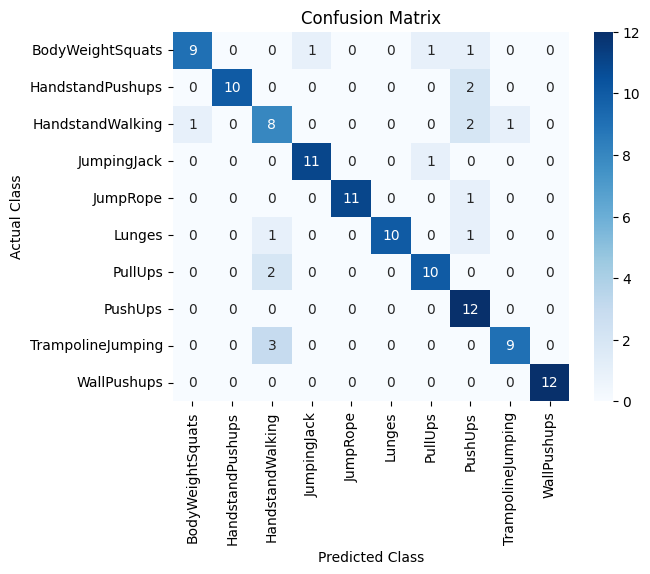

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LateFusionNetwork(num_classes=10, fine_tune=True)
model.load_state_dict(torch.load('best_model.pth'))

action = ['BodyWeightSquats', 'HandstandPushups', 'HandstandWalking', 'JumpingJack', 'JumpRope', 'Lunges', 'PullUps', 'PushUps', 'TrampolineJumping', 'WallPushups']
eval_data, TP, FP, FN, TN = validate_CNN(model, test_framevideostack_loader, device, action)